In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
from scipy import fft

import sys
sys.path.insert(0,'..')
import specsens as ss

In [124]:
sample_freq = 1e6  # in Hz
length = .1  # in s
signal_power = 0.0  # in dB
noise_power = 0.0  # in dB

# create the signal
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
# sig = wm.get_soft(f_center=1e5, power=signal_power, dB=True)
# sig = wm.get_soft(f_center=-1e5, power=signal_power, dB=True)
sig = wm.get_soft(f_center=3e5, power=signal_power, dB=True)
sig += wm.get_soft(f_center=-3e5, power=signal_power, dB=True)

# create the noise
# wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_power, dB=True)

# ensure noise and signal have same length
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)
both1 = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# note, that Parseval's theorem holds
print("Freq energy:  %.2f" % (np.sum(np.abs(fft.fft(both1))**2)/sample_freq))
print("Time energy:  %.2f" % (np.sum(np.abs(both1)**2 * length)))

Signal power: 3.01 dB
Noise power:  -0.02 dB
SNR:          3.03 dB
Num samples:  100000 
Freq energy:  29928.00
Time energy:  29928.00


In [125]:
def fir_bandpass(x, f_min, f_max, f_sample, n_taps=255):
    return fir_bandpass_helper(x,
                               f_center=(f_min + f_max) * .5,
                               f_width=np.abs(f_max - f_min),
                               f_sample=f_sample,
                               n_taps=n_taps)


def fir_bandpass_helper(x, f_center, f_width, f_sample, n_taps=255):
    fir = signal.firwin(n_taps, f_width * .5, fs=f_sample, window='hamming')
    n = np.arange(0, n_taps)
    fir = fir * np.exp(1.j * 2 * np.pi * n * f_center * 1. / f_sample)
    return signal.fftconvolve(x, fir, mode='valid')


both = bandpass(both1, f_min=-200000, f_max=-400000, f_sample=sample_freq)

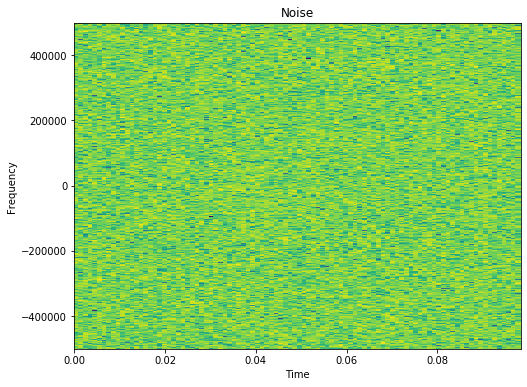

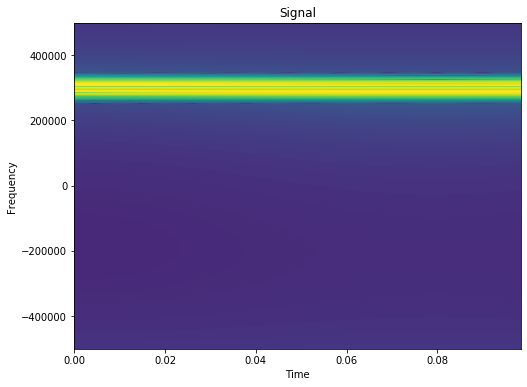

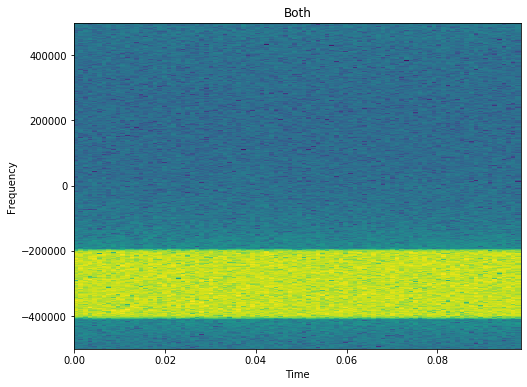

In [111]:
# Plot the spectogram with our short time Fourier transform
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [112]:
def mme_thr(n, l, pfa=0.1, m=1):
    tw = ss.TracyWidom(beta=1)
    fac1 = (np.sqrt(n) + np.sqrt(m * l))**2 / (np.sqrt(n) - np.sqrt(m * l))**2 
    fac2 = 1 + ((np.sqrt(n) + np.sqrt(m * l))**(-2 / 3) /
                (n * m * l)) * tw.cdfinv(1 - pfa)
    return fac1 * fac2


def eme_thr(n, l, pfa=0.1, m=1):
    fac1 = np.sqrt(2. / (m * n)) * stats.norm.isf(pfa) + 1
    fac2 = n / (np.sqrt(n) - np.sqrt(m * l))**2
    return fac1 * fac2


def corr(x, l):
    x = np.reshape(x, (-1, 1))
    r = np.zeros((l, l), dtype=np.complex128)
    n = len(x) - l
    for i in range(0, n):
        r += np.dot(x[i:i + l], x[i:i + l].conj().T)
    return r / n


def mme(x, l=10):
    Rx = corr(x, l)
    eigvals = np.abs(linalg.eigvals(Rx))
    return np.max(eigvals) / np.min(eigvals)


def eme(x, l=10):
    Rx = corr(x, l)
    eigvals = np.abs(linalg.eigvals(Rx))
    energy = np.sum(np.abs(x)**2.) / len(x)
    return energy / np.min(eigvals)


def comp() 

print('mme thr', mme_thr(n=1e5, l=10))

Rx = corr(both, l=10)

eigvals = np.abs(linalg.eigvals(Rx))
val = np.max(eigvals) / np.min(eigvals)
print('mme raw', val)

Q = linalg.sqrtm(Rx)
Qinv = np.linalg.inv(Q)

Rxc = np.dot(np.dot(Qinv, Rx), Qinv)

eigvals = np.abs(linalg.eigvals(Rxc))
val = np.max(eigvals) / np.min(eigvals)
print('mme corr', val)

mme thr 1.040812172050927
mme raw 42183548.5567486
mme corr 1.0000000020084268


In [126]:
Rx = corr(both, l=10)


Rxc = np.dot(np.dot(Qinv, Rx), Qinv)

eigvals = np.abs(linalg.eigvals(Rxc))
val = np.max(eigvals) / np.min(eigvals)
print('mme corr', val)

mme corr 21.031243458213442


In [81]:
noi = np.mean(np.abs(both)**2.)*5*1.0178824100224824
noi

1.0004926315993727

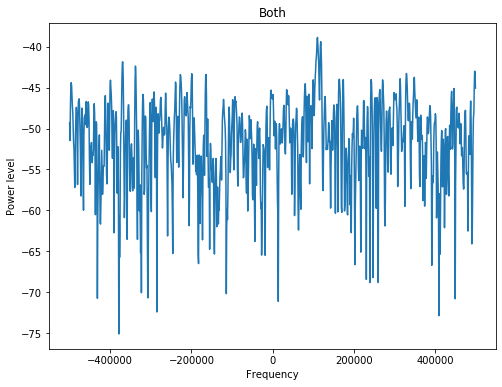

In [15]:
# Plot only 2nd FFT bin using our short time Fourier transform
sft = ss.Stft(n=1024, window='flattop')
f, x = sft.stft(both[1024:2048], sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.plot(f, x)
plt.title("Both")
plt.xlabel("Frequency")
plt.ylabel("Power level")
plt.show()

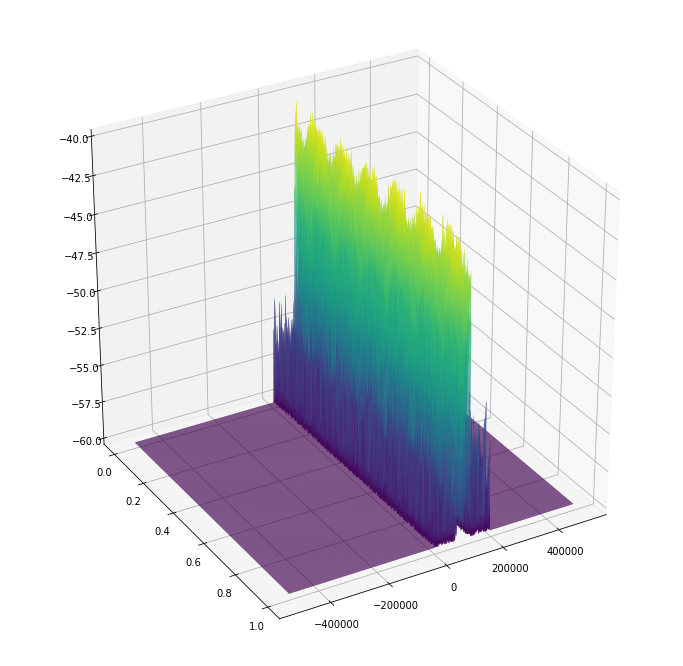

In [58]:
# Use our 3D plot 
ss.plot3d(sig=both,
          f_sample=sample_freq,
          window='flattop',
          nfft=1024,
          clip=-60,
          smooth=.5,
          crop=None,
          elev=30,
          azim=60,
          type='our')